<a href="https://colab.research.google.com/github/Ad603-tech/Deep-Learning-Projects/blob/main/Transfer_Learning_using_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

In [2]:
from torch._C import device
from torch.utils.data import dataloader

data_transforms = {
    'train': transforms.Compose([transforms.RandomResizedCrop(224),
                                 transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/MyDrive/hymenoptera_data'

image_datasets = {x : datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4)
for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


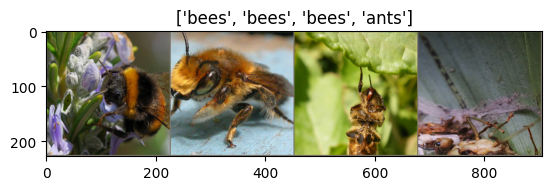

In [4]:
#Visualize images

def imshow(inp, title=None):
  """Display image for tensor"""
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp+mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.pause(0.001) # pause a bit so that plots are updated

  # Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

  #Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [7]:
# general function to train a model.
# Scheduling the learning rate using LR schedular object
# Saving the best model

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
  since = time.time()

  #Create temporary directory to save training checkpoints
  with TemporaryDirectory() as tempdir:
    best_model_params_path = os.path.join(tempdir,'best_model_params.pt')

    torch.save(model.state_dict(), best_model_params_path)
    best_acc = 0.0

    for epoch in range(num_epochs):
      print(f"Epoch {epoch}/{num_epochs - 1}")
      print('-' * 10)

      #Each epoch has a training and validation phase
      for phase in ['train', 'val']:
        if phase == 'train':
          model.train()  # Set model to training mode
        else:
          model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

                # iterate over the data

        for inputs, labels in dataloaders[phase]:
          inputs = inputs.to(device)
          labels = labels.to(device)

                    # zero the parameter gradients
          optimizer.zero_grad()

                    #forward
                    #track history if only in train

          with torch.set_grad_enabled(phase == 'train'):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

                      #backward + optimize only if in training phase
            if phase == 'train':
              loss.backward()
              optimizer.step()

                    # statistics
          running_loss += loss.item() * inputs.size(0)
          running_corrects += torch.sum(preds == labels.data)
        if phase == 'train':
          scheduler.step()

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
        if phase == 'val' and epoch_acc > best_acc:
          best_acc = epoch_acc
          torch.save(model.state_dict(), best_model_params_path)
      print()
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

      # load best model weights
    model.load_state_dict(torch.load(best_model_params_path))
  return model







In [8]:
def visualize_model(model, num_images=6):
  was_training = model.training
  model.eval()
  images_so_far = 0
  fig = plt.figure()

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['val']):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      for j in range(inputs.size()[0]):
        images_so_far += 1
        ax = plt.subplot(num_images//2, 2, images_so_far)
        ax.axis('off')
        ax.set_title(f'predicted: {class_names[preds[j]]}')
        imshow(inputs.cpu().data[j])

        if images_so_far == num_images:
          model.train(mode=was_training)
          return
    model.train(model=was_training)

In [9]:

# load a pretrained model and reset final FC layer

model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

#Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

#Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 134MB/s]


In [10]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.6937 Acc: 0.6598
val Loss: 0.2487 Acc: 0.9150

Epoch 1/24
----------
train Loss: 0.4739 Acc: 0.7869
val Loss: 0.2249 Acc: 0.9281

Epoch 2/24
----------
train Loss: 0.5227 Acc: 0.7910
val Loss: 0.3649 Acc: 0.8824

Epoch 3/24
----------
train Loss: 0.5022 Acc: 0.7910
val Loss: 0.2195 Acc: 0.9020

Epoch 4/24
----------
train Loss: 0.7092 Acc: 0.7213
val Loss: 0.2096 Acc: 0.9020

Epoch 5/24
----------
train Loss: 0.5162 Acc: 0.8279
val Loss: 0.3920 Acc: 0.8758

Epoch 6/24
----------
train Loss: 0.5284 Acc: 0.7951
val Loss: 0.2399 Acc: 0.8889

Epoch 7/24
----------
train Loss: 0.4268 Acc: 0.8238
val Loss: 0.2007 Acc: 0.9216

Epoch 8/24
----------
train Loss: 0.3165 Acc: 0.8689
val Loss: 0.1553 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.3589 Acc: 0.8566
val Loss: 0.1510 Acc: 0.9281

Epoch 10/24
----------
train Loss: 0.2958 Acc: 0.8852
val Loss: 0.1792 Acc: 0.9216

Epoch 11/24
----------
train Loss: 0.2674 Acc: 0.8689
val Loss: 0.1957 Acc: 0.9150

Epoch 12/24
----------
t

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


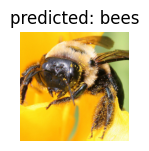

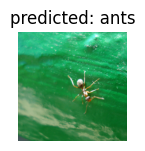

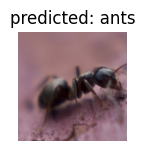

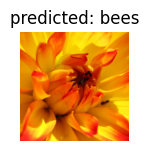

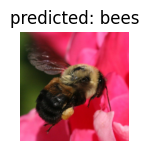

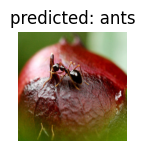

In [11]:
visualize_model(model_ft)

In [15]:
# ConvNet as fixed feature extractor

model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
  param.requires_grad = False

# Parameters of newly constructed modules have requires_grad = True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Only parameters of final layer has optimized
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


In [16]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.5682 Acc: 0.6803
val Loss: 0.1799 Acc: 0.9412

Epoch 1/24
----------
train Loss: 0.4469 Acc: 0.8115
val Loss: 0.2019 Acc: 0.9346

Epoch 2/24
----------
train Loss: 0.4611 Acc: 0.7992
val Loss: 0.1638 Acc: 0.9608

Epoch 3/24
----------
train Loss: 0.4300 Acc: 0.8115
val Loss: 0.1994 Acc: 0.9346

Epoch 4/24
----------
train Loss: 0.4465 Acc: 0.8033
val Loss: 0.4103 Acc: 0.8235

Epoch 5/24
----------
train Loss: 0.5076 Acc: 0.7951
val Loss: 0.2124 Acc: 0.9281

Epoch 6/24
----------
train Loss: 0.5124 Acc: 0.7828
val Loss: 0.2641 Acc: 0.9020

Epoch 7/24
----------
train Loss: 0.3942 Acc: 0.8156
val Loss: 0.1789 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.3507 Acc: 0.8443
val Loss: 0.2048 Acc: 0.9281

Epoch 9/24
----------
train Loss: 0.4017 Acc: 0.8197
val Loss: 0.1634 Acc: 0.9542

Epoch 10/24
----------
train Loss: 0.3794 Acc: 0.8566
val Loss: 0.1603 Acc: 0.9542

Epoch 11/24
----------
train Loss: 0.2872 Acc: 0.8689
val Loss: 0.1711 Acc: 0.9412

Epoch 12/24
----------
t

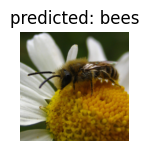

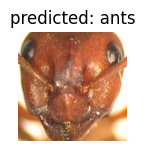

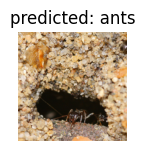

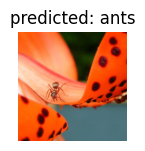

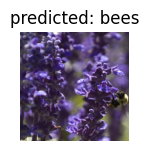

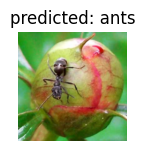

In [17]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [18]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

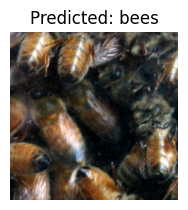

In [20]:
visualize_model_predictions(
    model_conv,
    img_path='/content/drive/MyDrive/hymenoptera_data/val/bees/1032546534_06907fe3b3.jpg'
)

plt.ioff()
plt.show()